# Lab Session: Introduction to spectral unmixing
Professor: <span style="color:blue">lucas.drumetz@imt-atlantique.fr</span>

The goal of this lab is to get familiar with the unmixing of hyperspectral images and the techniques to solve this problem. We will implement a simple unmixing chain on an ideal simulated case first, and then on a real hyperspectral image.

# Part I: Simulated data

In this section, we will generate some simulated hyperspectral data by drawing abundances from a uniform distribution on the simplex, then implement an endmember extraction algorithm, and finally estimate abundances.

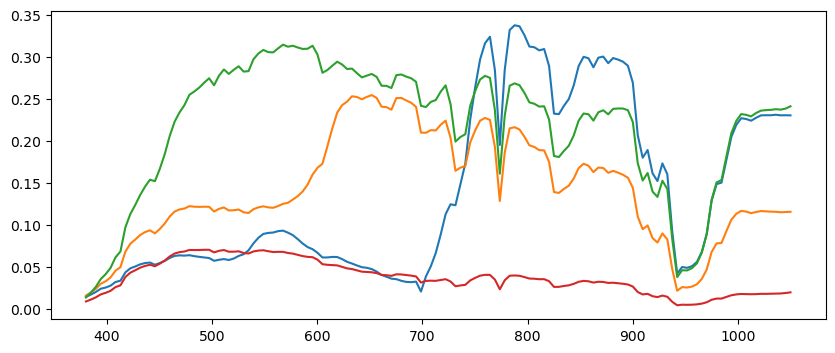

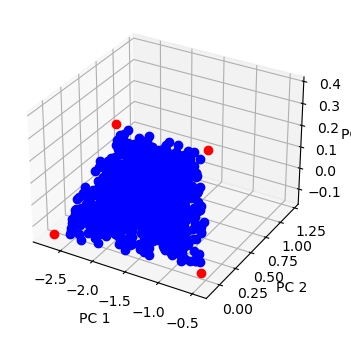

In [116]:
import numpy as np
import scipy.stats
import scipy.io as sio
import matplotlib.pyplot as plt

from pca_viz import pca_viz

## this code snippet generates 1000 points following a uniform distribution on the unit simplex with 3 vertices

alpha = [1,1,1,1]
A_synth_true = scipy.stats.dirichlet.rvs(alpha, size=1000).T

# this part loads some pure spectra taken from real data (vegetation/metallic sheets/asphalt/concrete)

endmembers = sio.loadmat("endmembers_houston.mat")
L = np.shape(endmembers['S0'])[0]
wavelengths = np.linspace(380,1050,L) #
S = endmembers['S0'][:,0:4]

plt.figure()
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(wavelengths, S)

synth_data = np.dot(S,A_synth_true) # X = SA

plt.rcParams["figure.figsize"] = (10,4)
pca_viz(synth_data,S) # this function is used to represent the data in a 3D space 
#(even though they actually live in an L-dimensional space)

How many spectral bands are there? Can you recognize some of the materials by their spectra? Implement the Successive Projection Algorithm (SPA) as seen during the lecture. Apply it on the synthetic dataset. Check the quality of the extracted endmembers. Are they exactly the same as the original endmembers? Why? Try with 4 endmembers.

In [170]:
# useful functions : np.linalg.norm, np.dot, np.outer, np.argmax, np.apply_along_axis

P = 4 # number of endmembers (materials)

def SPA(data, r):
    def convex_function(x):
        return np.linalg.norm(x)**2

    m, n = X.shape
    K = set()
    R = X.copy()
    k = 1

    while np.any(R) and k <= r:
        k_star = np.argmax(np.apply_along_axis(convex_function, 0, R))
        uj = R[:, k_star] / np.linalg.norm(R[:, k_star])

        R -= np.outer(uj, np.dot(uj, R))
        K.add(k_star)
        k += 1

    return X[:, list(K)], list(K)
        

[386, 223, 470, 439]


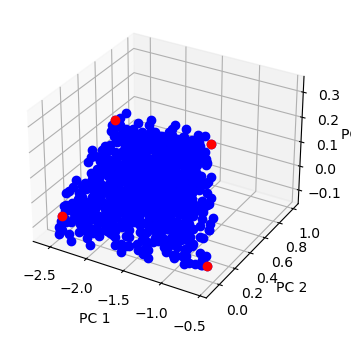

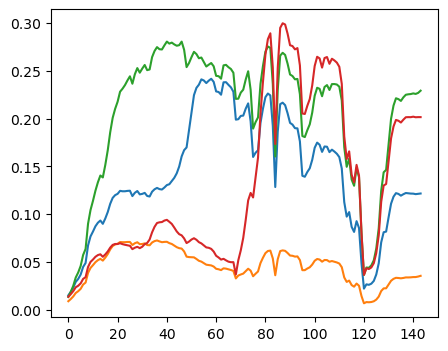

In [181]:
endmembers_synth,endmember_coordinates_synth = SPA(synth_data,P)

print(endmember_coordinates_synth)
#print(endmembers_synth)
# visualize the results

# %matplotlib notebook 
pca_viz(synth_data,endmembers_synth)

plt.figure()
plt.rcParams["figure.figsize"] = (5,4)
plt.plot(endmembers_synth)

In [182]:
# compute the abundances using the FCLSU algorithm (constrained least squares) and compare with the real values.

from FCLSU import FCLSU

A_synth = FCLSU(synth_data,endmembers_synth)



iteration  0  of  1000 , rel_phi = 0.5124792843429202
iteration  1  of  1000 , rel_phi = 0.38172410858779887
iteration  2  of  1000 , rel_phi = 0.8431315920117568
iteration  3  of  1000 , rel_phi = 0.47451188175185166
iteration  4  of  1000 , rel_phi = 0.5129508325243927
iteration  5  of  1000 , rel_phi = 0.29460452775366897
iteration  6  of  1000 , rel_phi = 0.20779979175555086
iteration  7  of  1000 , rel_phi = 0.17507735261360802
iteration  8  of  1000 , rel_phi = 0.13917130995464158
iteration  9  of  1000 , rel_phi = 0.11711909075263734
iteration  10  of  1000 , rel_phi = 0.11539929233978129
iteration  11  of  1000 , rel_phi = 0.08462630097781645
iteration  12  of  1000 , rel_phi = 0.09074406864372568
iteration  13  of  1000 , rel_phi = 0.069891557894036
iteration  14  of  1000 , rel_phi = 0.07598278369773809
iteration  15  of  1000 , rel_phi = 0.06051704212894043
iteration  16  of  1000 , rel_phi = 0.06388765124534355
iteration  17  of  1000 , rel_phi = 0.051382367530239996
iterat

Compare for a few pixels the estimated abundances with the true ones. Are they easily comparable? Why? How can we fix this?

In [192]:
# Access abundances for the first pixel
abundances_first_pixel = A_synth[:, 0]
print(abundances_first_pixel)
# Access abundances for the first endmember across all pixels
for i in range (1000):
    print(A_synth[0, i])
    


[0.01422424 0.29299826 0.64177354 0.05207342]
0.014224240143043214
0.3584996258144916
0.13487267612935017
-2.91479846438088e-07
0.046072010248335654
0.505604994353576
0.47735941857523007
-1.918746967923402e-07
0.6299919951664014
0.0046937790634893305
0.12923766772936526
0.4449846340982107
0.2615319739129596
0.10133488317509455
0.24949331408822914
0.3768899461132529
0.6679774102295735
0.00023885555981195127
0.10185128648032872
0.041467903959655425
0.018899934545132325
0.4696957489143897
-5.561431508355146e-07
0.00014162114887096545
0.30119901624929163
0.030956484880061436
0.20451062966724293
0.00013497967528542046
0.6566475255941968
-1.4465612471643557e-06
0.35199555188687043
0.10827890041363072
0.29629769529357997
0.19290299912767478
0.09297836807091255
0.7844219665964105
0.38621868100242196
0.8470757702392216
0.3723488121150372
0.6762885392631145
0.00013680061129469682
0.21624191065754647
0.3897380105190528
0.05496061805935703
0.23692643973981253
0.2964851730446063
-1.5998122244276958

# Part II: Real Data

In this part, we are going to unmix a real image acquired by the airborne sensor AVIRIS over Calaveras Reservoir, California, USA. Don't hesitate to use Google maps to access a higher spatial resolution image over this scene:

https://www.google.fr/maps/place/Calaveras+Reservoir/@37.4777265,-121.8213273,4840m/data=!3m2!1e3!4b1!4m5!3m4!1s0x808fd026ab19d673:0x21f48327a3b3c623!8m2!3d37.4734195!4d-121.8192506

(199, 199, 192)
1.0
0.0


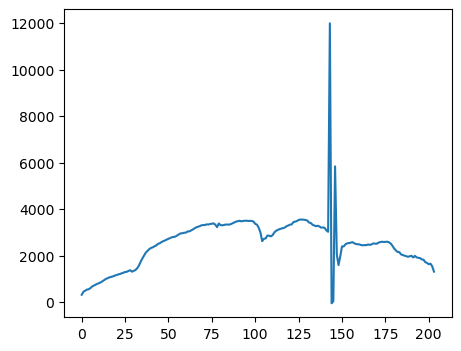

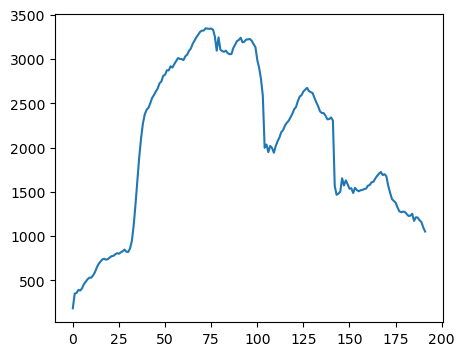

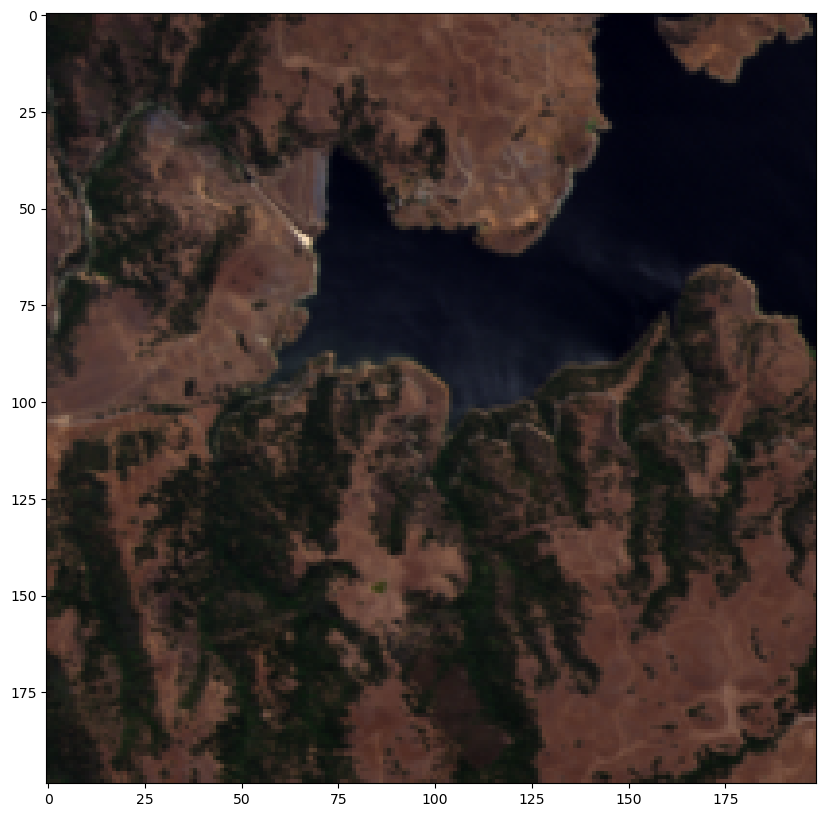

In [173]:
data = sio.loadmat("moffett1.mat")
im = data['im'].astype("double")
imrgb = data['imrgb']

plt.figure()
plt.plot(im[50,50,:]) # plot one pixel

im = np.delete(im,slice(200,224),axis =2) # delete noisy or corrupted bands
im = np.delete(im,slice(142,150),axis =2)
plt.figure()
plt.plot(im[35,24,:]) # plot one pixel after this

im = im[1:200,1:200,:] # select crop on which we will work

im = (im - np.amin(im))/(np.amax(im)-np.amin(im)) # rescale image

print(im.shape)
print(np.amax(im))
print(np.amin(im))


plt.figure(figsize=(20,10))
plt.imshow(imrgb[1:200,1:200,:])

[m,n,L] = im.shape
rgb_small =imrgb[1:200,1:200,:]


In [86]:
im.shape

(199, 199, 192)

In [87]:
rgb_small.shape

(199, 199, 3)

First, reshape the hyperspectral image as a $L\times N$ matrix, using the reshape function from numpy

In [174]:
# TO DO
# Reshape the hyperspectral image as a L x N matrix
n_r,n_c,n_b = im.shape
reshape_im = np.reshape(im,(n_r*n_c,n_b))
print(reshape_im.shape)

(39601, 192)


Use the SPA algorithm that you coded above to extract endmembers from the data. Use 4 endmembers at first. Represents the extracted pixels on the rgb image and try to visually identify them (you can use google maps as well). The "pca_viz" function provided represents the dataset and the extracted endmembers on a 3D space in the "best" way possible. 

Endmember coordinates: [11609, 35290, 29339, 27740]


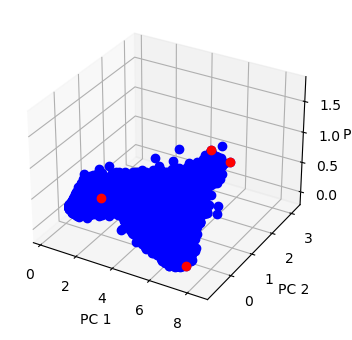

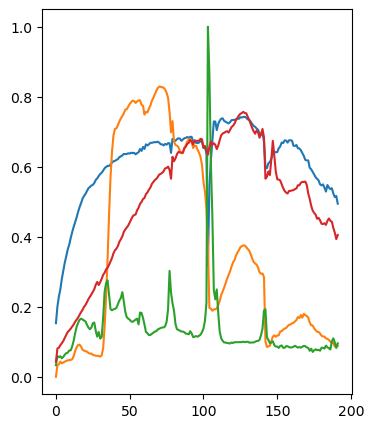

In [235]:
endmembers, endmember_coordinates = SPA(reshape_im.T, 4)
#print("Endmembers:", endmembers)
print("Endmember coordinates:", endmember_coordinates)
pca_viz(reshape_im.T, endmembers)

plt.figure()
plt.rcParams["figure.figsize"] = (4,6)
plt.plot(endmembers)

In [ ]:
from pca_viz import pca_viz
# %matplotlib notebook

from mpl_toolkits.mplot3d import axes3d  

# pca_viz(data,endmembers) ## represents the dataset and extracted endmembers in a 3 dimensional space

Try different values for P until you are satified with the results. Then compute the abundances using the same function as before, and display them as images, together with the corresponding endmembers. Compare the results with the RGB image, and with the high res image from Google Maps

Endmember coordinates: [5401, 395, 13004, 29338, 11609, 35290, 29339, 27740]


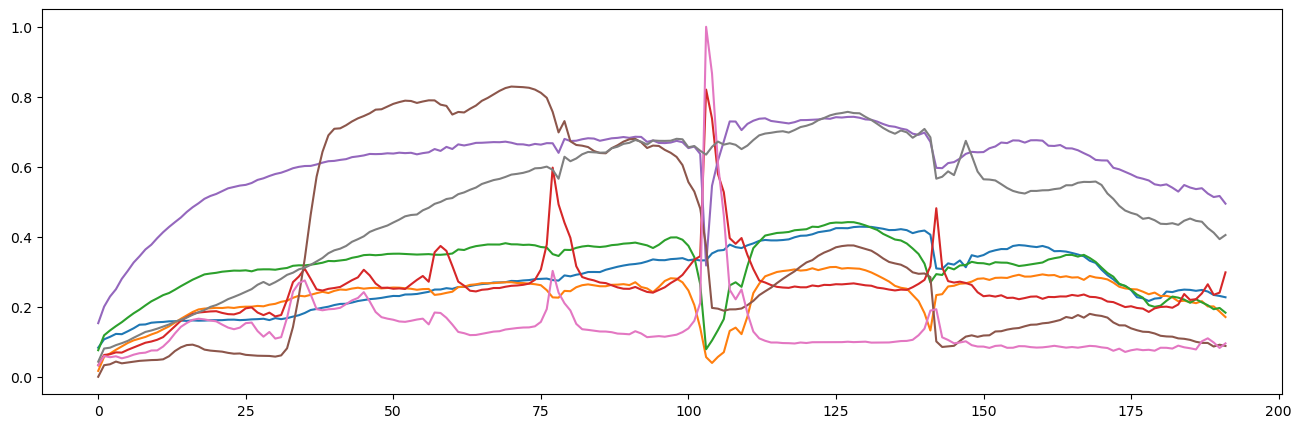

In [210]:
endmembers, endmember_coordinates = SPA(reshape_im.T, 8)
#print("Endmembers:", endmembers)
print("Endmember coordinates:", endmember_coordinates)
#pca_viz(reshape_im.T, endmembers)

plt.figure()
plt.rcParams["figure.figsize"] = (5,30)
plt.plot(endmembers)

In [211]:
# Compute the abundances
from FCLSU import FCLSU

A_synth = FCLSU(reshape_im.T,endmembers)


iteration  0  of  1000 , rel_phi = 0.6704400342485721
iteration  1  of  1000 , rel_phi = 0.28771402501257526
iteration  2  of  1000 , rel_phi = 0.018601951567091792
iteration  3  of  1000 , rel_phi = 0.1648577893036465
iteration  4  of  1000 , rel_phi = 0.06815708816294008
iteration  5  of  1000 , rel_phi = 0.006700070485399709
iteration  6  of  1000 , rel_phi = 0.01772823056575421
iteration  7  of  1000 , rel_phi = 0.017522317329043066
iteration  8  of  1000 , rel_phi = 0.0102194875607568
iteration  9  of  1000 , rel_phi = 0.0018890248498394221
iteration  10  of  1000 , rel_phi = 0.017444950481064325
iteration  11  of  1000 , rel_phi = 0.0042482099889981015
iteration  12  of  1000 , rel_phi = 0.01358178255976448
iteration  13  of  1000 , rel_phi = 0.0027434055803538904
iteration  14  of  1000 , rel_phi = 0.009881250796260259
iteration  15  of  1000 , rel_phi = 0.0030113976449229344
iteration  16  of  1000 , rel_phi = 0.007410490475196139
iteration  17  of  1000 , rel_phi = 0.006940232

iteration  142  of  1000 , rel_phi = 0.0002350475171950674
iteration  143  of  1000 , rel_phi = 0.00023545459658360092
iteration  144  of  1000 , rel_phi = 0.00023583424255227908
iteration  145  of  1000 , rel_phi = 0.00023616423904072886
iteration  146  of  1000 , rel_phi = 0.00023648430354561854
iteration  147  of  1000 , rel_phi = 0.00023673869863265518
iteration  148  of  1000 , rel_phi = 0.00023700413457557014
iteration  149  of  1000 , rel_phi = 0.00023722237479624475
iteration  150  of  1000 , rel_phi = 0.0002374128999996212
iteration  151  of  1000 , rel_phi = 0.00023757446618547472
iteration  152  of  1000 , rel_phi = 0.000237698027310132
iteration  153  of  1000 , rel_phi = 0.00023780149873811187
iteration  154  of  1000 , rel_phi = 0.00023787443732644741
iteration  155  of  1000 , rel_phi = 0.00023791944806210634
iteration  156  of  1000 , rel_phi = 0.0002379395542281822
iteration  157  of  1000 , rel_phi = 0.0002379226933046648
iteration  158  of  1000 , rel_phi = 0.0002378

iteration  283  of  1000 , rel_phi = 0.00015429113711403505
iteration  284  of  1000 , rel_phi = 0.00015348988976962328
iteration  285  of  1000 , rel_phi = 0.00015269042534567999
iteration  286  of  1000 , rel_phi = 0.00015189303596398402
iteration  287  of  1000 , rel_phi = 0.00015109747131072937
iteration  288  of  1000 , rel_phi = 0.00015030383442123636
iteration  289  of  1000 , rel_phi = 0.00014950957093493866
iteration  290  of  1000 , rel_phi = 0.00014872156991924777
iteration  291  of  1000 , rel_phi = 0.00014793474000262722
iteration  292  of  1000 , rel_phi = 0.00014715034003369022
iteration  293  of  1000 , rel_phi = 0.00014636831153356424
iteration  294  of  1000 , rel_phi = 0.0001455882924163303
iteration  295  of  1000 , rel_phi = 0.00014481055719115413
iteration  296  of  1000 , rel_phi = 0.00014403520317545174
iteration  297  of  1000 , rel_phi = 0.000143262187733632
iteration  298  of  1000 , rel_phi = 0.00014249135392922614
iteration  299  of  1000 , rel_phi = 0.0001

iteration  423  of  1000 , rel_phi = 6.79327975384574e-05
iteration  424  of  1000 , rel_phi = 6.750755853583618e-05
iteration  425  of  1000 , rel_phi = 6.708477194156217e-05
iteration  426  of  1000 , rel_phi = 6.666444294383706e-05
iteration  427  of  1000 , rel_phi = 6.624651526261506e-05
iteration  428  of  1000 , rel_phi = 6.583098981689752e-05
iteration  429  of  1000 , rel_phi = 6.541782645579968e-05
iteration  430  of  1000 , rel_phi = 6.500702574538295e-05
iteration  431  of  1000 , rel_phi = 6.459855863236311e-05
iteration  432  of  1000 , rel_phi = 6.419242453216768e-05
iteration  433  of  1000 , rel_phi = 6.378860174644004e-05
iteration  434  of  1000 , rel_phi = 6.338708874492553e-05
iteration  435  of  1000 , rel_phi = 6.298786916966544e-05
iteration  436  of  1000 , rel_phi = 6.259094086562328e-05
iteration  437  of  1000 , rel_phi = 6.219629105760448e-05
iteration  438  of  1000 , rel_phi = 6.180391674202943e-05
iteration  439  of  1000 , rel_phi = 6.141380720766745e-0

iteration  564  of  1000 , rel_phi = 2.7310422800413218e-05
iteration  565  of  1000 , rel_phi = 2.7131369214513236e-05
iteration  566  of  1000 , rel_phi = 2.695302575002289e-05
iteration  567  of  1000 , rel_phi = 2.677581062355895e-05
iteration  568  of  1000 , rel_phi = 2.6599764613527828e-05
iteration  569  of  1000 , rel_phi = 2.6424879306564023e-05
iteration  570  of  1000 , rel_phi = 2.6251140901028915e-05
iteration  571  of  1000 , rel_phi = 2.607853630425978e-05
iteration  572  of  1000 , rel_phi = 2.590705374328395e-05
iteration  573  of  1000 , rel_phi = 2.5736682598253266e-05
iteration  574  of  1000 , rel_phi = 2.556741317362524e-05
iteration  575  of  1000 , rel_phi = 2.539923649492726e-05
iteration  576  of  1000 , rel_phi = 2.5232144161409686e-05
iteration  577  of  1000 , rel_phi = 2.506612821782814e-05
iteration  578  of  1000 , rel_phi = 2.4901181067356798e-05
iteration  579  of  1000 , rel_phi = 2.4737295392615198e-05
iteration  580  of  1000 , rel_phi = 2.45744641

iteration  704  of  1000 , rel_phi = 1.0767255712994335e-05
iteration  705  of  1000 , rel_phi = 1.0695435426761035e-05
iteration  706  of  1000 , rel_phi = 1.0624089532781181e-05
iteration  707  of  1000 , rel_phi = 1.0553214959395536e-05
iteration  708  of  1000 , rel_phi = 1.0482808657194745e-05
iteration  709  of  1000 , rel_phi = 1.0412867594247939e-05
iteration  710  of  1000 , rel_phi = 1.0343388757546331e-05
iteration  711  of  1000 , rel_phi = 1.0274369151960977e-05
iteration  712  of  1000 , rel_phi = 1.0205805802929343e-05
iteration  713  of  1000 , rel_phi = 1.0137695751063097e-05
iteration  714  of  1000 , rel_phi = 1.0070036058356362e-05
iteration  715  of  1000 , rel_phi = 1.0002823803829418e-05
iteration  716  of  1000 , rel_phi = 9.936056086008365e-06


Perform the same unmixing procedure using more endmembers. Are all the endmembers relevant? 

In [ ]:
# no, not all of them a re relevant, because many of them are not pure, or many 

Endmember coordinates: [395, 5401, 29338, 29339, 31004, 11809, 13348, 18858, 17710, 23221, 34874, 13004, 21591, 11607, 11609, 35290, 27740, 29538, 10474, 13546]


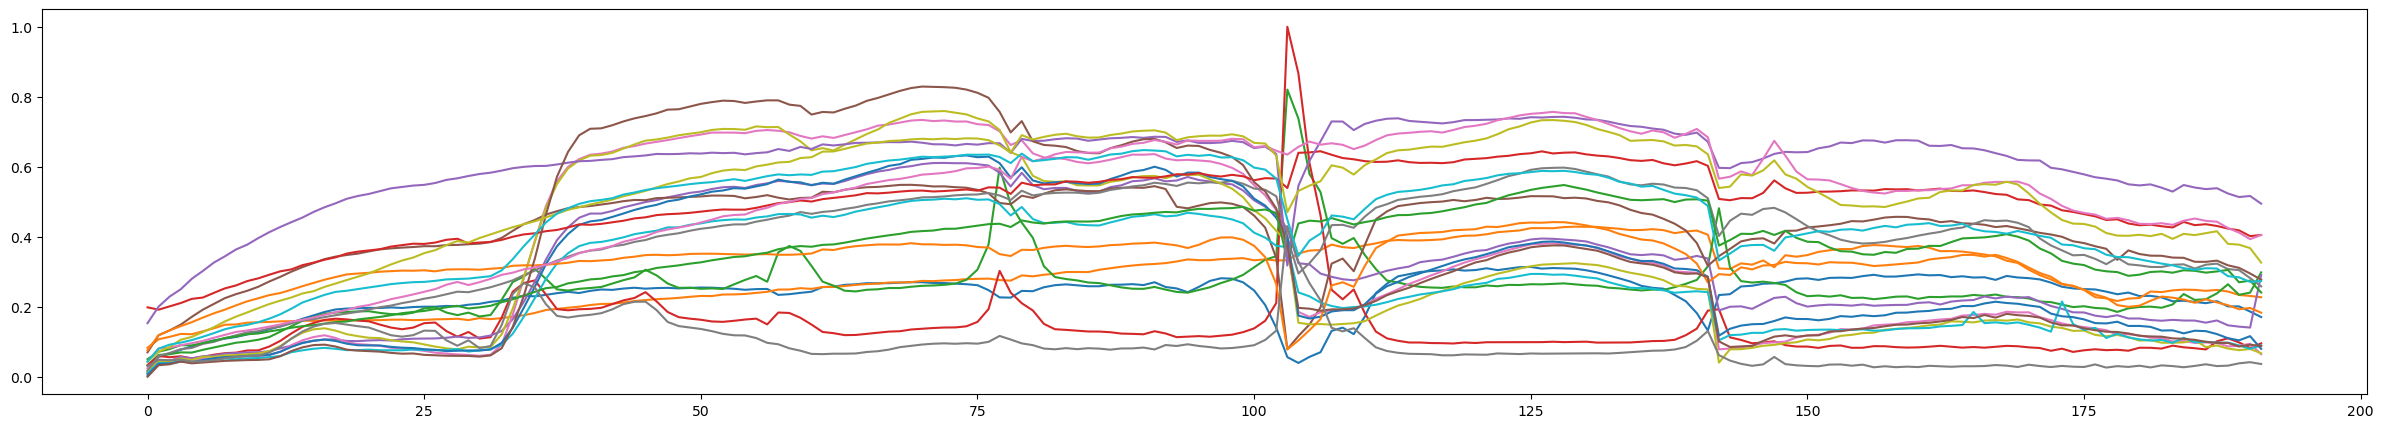

In [215]:
endmembers, endmember_coordinates = SPA(reshape_im.T, 20)
#print("Endmembers:", endmembers)
print("Endmember coordinates:", endmember_coordinates)
#pca_viz(reshape_im.T, endmembers)

plt.figure()
plt.rcParams["figure.figsize"] = (5,25)
plt.plot(endmembers)

To finish, we are going to use a variant of the abundance estimation algorithm which adds a sparsity-promoting regularization. Run it on the different configurations you identified before and compare the abundance maps.

In [240]:
from social_unmixing import social_unmixing

# parameters

groups = np.arange(0,P)
rho = 10
maxiter_ADMM = 200
algo = "fractional"
fraction = 0.5
tol_a = 10**(-5)
verbose = True

# regularization parameter
Lambda = 0.5 # this values controls the sparsity level. The larger the value, the sparser the solution.

A_sparse = social_unmixing(reshape_im.T,endmembers,groups,0,Lambda,rho,maxiter_ADMM,algo, \
                    fraction,tol_a, verbose)


iteration  0  of  200 , rel_A = 0.6055221366785539
iteration  1  of  200 , rel_A = 0.7716517487436038
iteration  2  of  200 , rel_A = 0.8963615389315838
iteration  3  of  200 , rel_A = 0.9183721062659413
iteration  4  of  200 , rel_A = 0.9250105393520487
iteration  5  of  200 , rel_A = 0.9236478573160992
iteration  6  of  200 , rel_A = 0.9191441164252594
iteration  7  of  200 , rel_A = 0.9147688423533262
iteration  8  of  200 , rel_A = 0.910942916856852
iteration  9  of  200 , rel_A = 0.9073260294981293
iteration  10  of  200 , rel_A = 0.9034626716212618
iteration  11  of  200 , rel_A = 0.8993253762236781
iteration  12  of  200 , rel_A = 0.8950335108101509
iteration  13  of  200 , rel_A = 0.891022276687835
iteration  14  of  200 , rel_A = 0.8882953344626562
iteration  15  of  200 , rel_A = 0.8860356465195041
iteration  16  of  200 , rel_A = 0.8834409540542306
iteration  17  of  200 , rel_A = 0.8807340349992785
iteration  18  of  200 , rel_A = 0.8780613490588351
iteration  19  of  200 ,

iteration  157  of  200 , rel_A = 0.8327069041469897
iteration  158  of  200 , rel_A = 0.8326743288784023
iteration  159  of  200 , rel_A = 0.8326419031037758
iteration  160  of  200 , rel_A = 0.8326097605557008
iteration  161  of  200 , rel_A = 0.8325780809786862
iteration  162  of  200 , rel_A = 0.8325467649113075
iteration  163  of  200 , rel_A = 0.8325158437647692
iteration  164  of  200 , rel_A = 0.8324851152000964
iteration  165  of  200 , rel_A = 0.8324544640895566
iteration  166  of  200 , rel_A = 0.8324239531797912
iteration  167  of  200 , rel_A = 0.8323938229650856
iteration  168  of  200 , rel_A = 0.8323643646181774
iteration  169  of  200 , rel_A = 0.8323354336405393
iteration  170  of  200 , rel_A = 0.8323066170577762
iteration  171  of  200 , rel_A = 0.832277751978911
iteration  172  of  200 , rel_A = 0.8322488285475814
iteration  173  of  200 , rel_A = 0.8322200614199727
iteration  174  of  200 , rel_A = 0.8321915082407738
iteration  175  of  200 , rel_A = 0.83216307907

In [226]:
endmembers.shape

(192, 20)

In [239]:
P = 20
Q = 10
groups = np.random.randint(1, P + 1, size=Q)

Generated groups: [18  8  7  4  9 13  6 13  9  2]


Finally, if you have time, try to unmix other areas of the whole image by changing the coordinates of the image in the first cell.